USER_AGENT environment variable not set, consider setting it to identify your requests.
/tmp/ipykernel_240086/558609828.py:19: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectordb = Chroma(persist_directory=persist_directory, embedding_function=embeddings)


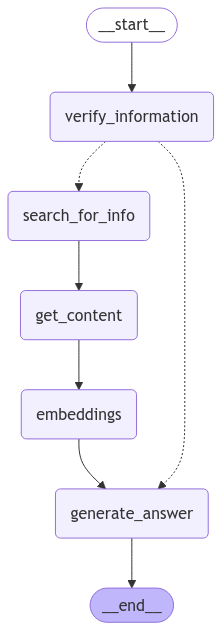

In [1]:
from typing import List, Dict, Any, TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools import DuckDuckGoSearchResults
from langchain.tools import tool
from langchain_core.documents import Document

from pydantic import BaseModel, Field

llm = ChatOpenAI(model_name="gpt-4o")
embeddings = OpenAIEmbeddings()


persist_directory = "chroma_db" 
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

class AgentState(TypedDict):
    """State schema for our chatbot"""
    query: str
    messages: str
    answer: str
    link: str
    document : Document

class Links(BaseModel):
    link: str = Field(description="The link of the best match")

def search_for_info(state: AgentState):
    web_query = llm.invoke(f"Rephrase user question to become a proper web search: {state['query']}")
    results = DuckDuckGoSearchResults().invoke(web_query.content)
    link = llm.with_structured_output(Links).invoke(f"Get the best match from these links to the following user question: {state['query']}. Search: {results}")
    return {"link": link.link}

def fetch_webpage_content(state:AgentState) -> Document:
    """Fetches the text content from a webpage URL."""
    link = state["link"]
    document = WebBaseLoader(link).load()
    return {"document": document}

def embbed_and_store(state: AgentState):
    splitted = text_splitter.split_documents(state["document"])
    vectordb.add_documents(splitted)
    return {"document": splitted}

def verify_information(state: AgentState):
    query = state["query"]
    score = vectordb.similarity_search_with_score(query)
    if score:
        if score[0][1] < 0.3:
            return {"document": [document[0] for document in score]}
    return {"document": None}
    
def answer(state: AgentState):
    prompt = ChatPromptTemplate.from_template("""
    The user wants to know some information about the following context:
    {documents}. 
    Be helpful and answer him with your best efforts.
    Question: {question}
""")
    chain = prompt | llm
    documents = state["document"]
    question = state["query"]
    answer = chain.invoke({"documents":documents,"question":question})
    return {"answer": answer.content}

def direct_path(state: AgentState):
    if state["document"]:
        return "generate_answer"
    return "search_for_info"

workflow = StateGraph(AgentState)

workflow.add_node("get_content",fetch_webpage_content)
workflow.add_node("search_for_info",search_for_info)
workflow.add_node("embeddings",embbed_and_store)
workflow.add_node("verify_information",verify_information)
workflow.add_node("generate_answer",answer)

workflow.add_conditional_edges("verify_information",
                               direct_path,
                               {"generate_answer":"generate_answer",
                                "search_for_info":"search_for_info"})

workflow.add_edge("search_for_info","get_content")
workflow.add_edge("get_content","embeddings")
workflow.add_edge("embeddings","generate_answer")
workflow.add_edge("generate_answer",END)

workflow.set_entry_point("verify_information")

app = workflow.compile()
app

In [2]:
app.invoke({"query":"What is an regression model?"})

{'query': 'What is an regression model?',
 'answer': 'A regression model is a type of supervised machine learning technique used to analyze the relationship between independent (input) and dependent (output) variables and predict continuous values. The ultimate goal of a regression algorithm is to plot a best-fit line or curve that represents this relationship.\n\nRegression models are valuable tools in fields like data science and statistics for predicting outcomes and understanding the influences of various factors on a particular variable of interest. These models generate predictions by estimating how changes in one or more independent variables lead to changes in the dependent variable, allowing them to forecast continuous outcomes based on new data inputs. \n\nKey forms of regression in machine learning include:\n\n1. **Linear Regression**: This is the most straightforward form of regression that models the linear relationship between a single independent variable and a dependent